In [1]:
import pandas as pd
import datetime as dt
import time
import numpy as np
import sys

In [2]:
oxford_policy = pd.read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv")
cols_to_keep = [col for col in list(oxford_policy.columns) if 'Flag' not in col]
oxford_policy = oxford_policy[cols_to_keep]

In [3]:
oxford_policy['Date'] = pd.to_datetime(oxford_policy['Date'].astype(str), format='%Y%m%d')
oxford_policy['Date'] = pd.to_datetime(oxford_policy['Date'], infer_datetime_format=True)
oxford_policy['Date'] = oxford_policy['Date'].dt.date
oxford_policy.rename(columns={'CountryName': 'Country'}, inplace=True)

#### data cleaning

### Loading JHU time series dataset

In [264]:
jhu_time = pd.read_csv("https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv")
jhu_time['Date'] = pd.to_datetime(jhu_time['Date'], infer_datetime_format=True)
jhu_time['Date'] = jhu_time['Date'].dt.date
jhu_time.rename(columns={'Country/Region': 'Country'}, inplace=True)
jhu_time.drop(columns=['Province/State', 'Lat', 'Long'], inplace=True)

jhu_time = jhu_time[jhu_time['Confirmed'] > 0.0]
#first_case = sub.groupby('Country')['Date'].min().reset_index().sort_values(by=['Country'])
jhu_time['Day Count'] = jhu_time.groupby('Country').cumcount() + 1
jhu_time

,Date,Country,Confirmed,Recovered,Deaths,Day Count
33,2020-02-24,Afghanistan,1.0,0.0,0.0,1
34,2020-02-25,Afghanistan,1.0,0.0,0.0,2
35,2020-02-26,Afghanistan,1.0,0.0,0.0,3
36,2020-02-27,Afghanistan,1.0,0.0,0.0,4
37,2020-02-28,Afghanistan,1.0,0.0,0.0,5
...,...,...,...,...,...,...
30700,2020-05-11,Zimbabwe,36.0,9.0,4.0,53
30701,2020-05-12,Zimbabwe,36.0,9.0,4.0,54
30702,2020-05-13,Zimbabwe,37.0,12.0,4.0,55
30703,2020-05-14,Zimbabwe,37.0,13.0,4.0,56


In [5]:
stats = jhu_time.groupby("Country")[['Confirmed', 'Recovered', 'Deaths']].max()
stats[stats.index == 'US']

,Confirmed,Recovered,Deaths
Country,,,
US,1442824.0,250747.0,87530.0


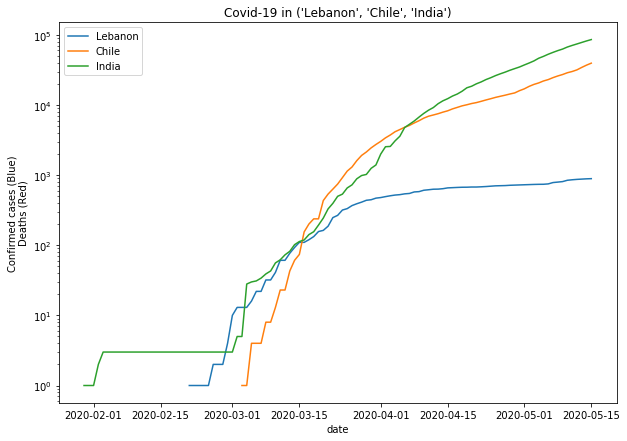

In [309]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

def plot_cases_death(*countries):
    fig, ax = plt.subplots(figsize=(10, 7))
    for country in countries:
        country = jhu_time[jhu_time['Country'] == country]
        g = sns.lineplot(x=country['Date'], y=country['Confirmed'],  ax=ax)
        #g = sns.lineplot(x=country['Date'], y=country['Deaths'],  color='red', ax=ax)
        g.set(xlabel='date', ylabel='Confirmed cases (Blue)\nDeaths (Red)', title='Covid-19 in {}'.format(countries))
        ax.set_yscale('log')
        #ax.axvline(us_soe, ls='--')
    plt.legend(countries)
    #plt.savefig('..\\..\\..\\..\\..\\Desktop\\leb_chile_india.png')
    plt.show()
    
plot_cases_death('Lebanon', 'Chile', 'India')


In [201]:
renaming = {'Czech republic': 'Czech Republic', 'Czechia': 'Czech Republic', 'Myanmar': 'Burma', 
          'West Bank and Gaza': 'Palestine', 'Brunei Darussalam': 'Brunei', 'Korea Republic of' : 'South Korea',
          'Korea, Rep.' : 'South Korea', 'Korea, South' : 'South Korea',  'Cote d\'Ivoire': 'Côte d\'Ivoire', 
            'North Macedonia Republic Of': 'North Macedonia', 'Congo': 'Congo (Brazzaville)', 
            'Congo DR': 'Congo (Kinshasa)', 'Congo, Dem. Rep.':'Congo (Kinshasa)',
          "Congo, Rep.":'Congo (Brazzaville)','Democratic Republic of Congo': 'Congo (Kinshasa)',  'Russian Federation': 'Russia', 'Egypt, Arab Rep.': 'Egypt',
          'Micronesia, Fed. Sts.':'Micronesia','Moldova Republic of': 'Moldova', 'Moldova Republic Of': 'Moldova', 
            'Lao PDR': 'Laos', 'Viet Nam': 'Vietnam', 'US': 'United States of America', "Bahamas, The": "Bahamas",
            "Gambia, The" : "Gambia", 'Iran, Islamic Rep.': "Iran", "Kyrgyzstan": "Kyrgyz Republic", 
            'St. Lucia' : "Saint Lucia", "Slovakia" : "Slovak Republic", 'Syrian Arab Republic' : "Syria", "Taiwan*" : "Taiwan",
           'United States' : 'United States of America', 
            'St. Vincent and the Grenadines' : 'Saint Vincent and the Grenadines', 'Venezuela, RB': 'Venezuela',
            'Yemen, Rep.' : 'Yemen'}

jhu_time['Country'] = jhu_time['Country'].replace(renaming)
oxford_policy['Country'] = oxford_policy['Country'].replace(renaming)
ox = oxford_policy['Country'].unique()
jhu = jhu_time['Country'].unique()

[cnt for cnt in jhu if cnt not in ox]


['Antigua and Barbuda',
 'Armenia',
 'Bahamas',
 'Belarus',
 'Cabo Verde',
 'Cambodia',
 'Comoros',
 'Diamond Princess',
 'Equatorial Guinea',
 'Eritrea',
 'Fiji',
 'Grenada',
 'Guinea-Bissau',
 'Guinea',
 'Haiti',
 'Holy See',
 'Latvia',
 'Liechtenstein',
 'MS Zaandam',
 'Maldives',
 'Malta',
 'Monaco',
 'Montenegro',
 'North Macedonia',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Vincent and the Grenadines',
 'Sao Tome and Principe',
 'Tajikistan',
 'Timor-Leste',
 'Togo',
 'Western Sahara']

#### Merging Oxford Policy and JHU

In [9]:
merged = pd.merge(oxford_policy, jhu_time, on=['Country', 'Date'], how='left')
merged

,Country,CountryCode,Date,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,...,StringencyIndex,StringencyIndexForDisplay,LegacyStringencyIndex,LegacyStringencyIndexForDisplay,Province/State,Lat,Long,Confirmed,Recovered,Deaths
0,Aruba,ABW,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN
1,Aruba,ABW,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2,Aruba,ABW,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN
3,Aruba,ABW,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN
4,Aruba,ABW,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31705,Kosovo,RKS,2020-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,94.71,NaN,93.57,NaN,42.602636,20.902977,919.0,671.0,29.0
31706,Kosovo,RKS,2020-05-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,94.71,NaN,93.57,NaN,42.602636,20.902977,919.0,671.0,29.0
31707,Kosovo,RKS,2020-05-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,94.71,NaN,93.57,NaN,42.602636,20.902977,944.0,690.0,29.0
31708,Kosovo,RKS,2020-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,94.71,NaN,93.57,NaN,42.602636,20.902977,944.0,690.0,29.0


##### Cleaning/Preparing World Bank data and preparing for merge on larger data frame 

In [10]:
def load_wb_data(filename, metric_name, year='2018'):
    '''
    '''
    df = pd.read_excel('data/' + filename, sheet_name='Data', header=3) 
    df = df[df.columns[4:]]
    df = df.ffill(axis=1)[year].to_frame().rename(columns={year: metric_name})
    
    return df
    
def country_index():
    '''
    '''
    idx = pd.read_excel('data/popabove65.xls', sheet_name='Data', header=3, usecols = ["Country Name"])
    idx.rename(columns={'Country Name': 'Country'}, inplace=True)
    
    return idx

In [206]:
idx = country_index()
pop_old = load_wb_data('popabove65.xls', 'Share Pop 65+')
hbed = load_wb_data('hospbeds.xls', 'Hospital Beds per 1k')
life_exp = load_wb_data('life_exp.xls', 'Life Expectancy')
doc_per1k = load_wb_data('doc_per1k.xls', 'Physicians per 1k')
hc_coverage = load_wb_data('UHC service coverage index.xls', 'Universal Health Care Coverage Index')
diabetes_prev = load_wb_data('diabetes_prev.xls', 'Diabetes Prevalence', year='2019')
hc_exp_cap = load_wb_data('hc_exp_capita.xls', 'Current Health Expenditure Per Capita, PPP', year='2017')
gdp = load_wb_data('gdp.xls', 'GDP')
pop = load_wb_data('pop_thousands.xls', 'Population') 

wb_data = pd.concat([idx, gdp, pop, pop_old, hbed, life_exp, doc_per1k, hc_coverage, diabetes_prev, hc_exp_cap], axis=1)
wb_data['Country'] = wb_data['Country'].replace(renaming)
wb_data

,Country,GDP,Population,Share Pop 65+,Hospital Beds per 1k,Life Expectancy,Physicians per 1k,Universal Health Care Coverage Index,Diabetes Prevalence,"Current Health Expenditure Per Capita, PPP"
0,Aruba,2.700559e+09,105845.0,13.550947,NaN,76.152000,1.1200,NaN,11.6,NaN
1,Afghanistan,1.936297e+10,37172386.0,2.584927,0.5,64.486000,0.2840,37.0,9.2,174.730637
2,Angola,1.057510e+11,30809762.0,2.216374,0.8,60.782000,0.2149,40.0,4.5,185.854034
3,Albania,1.510250e+10,2866376.0,13.744736,2.9,78.458000,1.1998,59.0,9.0,759.670000
4,Andorra,3.236544e+09,77006.0,NaN,2.5,NaN,3.3333,NaN,7.7,5237.241699
...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,7.938991e+09,1845300.0,NaN,NaN,72.195122,NaN,NaN,NaN,NaN
260,Yemen,2.691440e+10,28498687.0,2.876270,0.7,66.096000,0.3104,42.0,5.4,139.005066
261,South Africa,3.682889e+11,57779622.0,5.318005,2.8,63.857000,0.9101,69.0,12.7,1097.819214
262,Zambia,2.672007e+10,17351822.0,2.099678,2.0,63.510000,0.0913,53.0,4.5,180.270660


#### Data exploration/cleaning: Create a list of countries from the World Bank data that have any NaNs and checks list against the Oxford Policy dataframe demonstrate how countries would be lost if countries with NaN's are dropped. 

In [208]:
def missing_countries(df):
    missing_countries = []
    for col in df.columns[1:]:
        missing_countries += list(df[df[col].isna()]['Country'])
    return set(missing_countries)

s = missing_countries(wb_data)
to_drop = set(oxford_policy['Country'].unique()).intersection(s)
print('Num. countries with NaNs:', len(s))
print('Countries with Nan and in Oxford data frame', to_drop)

Num. countries with NaNs: 40
Countries with Nan and in Oxford data frame {'South Sudan', 'Andorra', 'Bermuda', 'Aruba', 'San Marino', 'Guam', 'Palestine', 'Puerto Rico', 'Kosovo', 'Somalia', 'Greenland', 'Dominica'}


#### There are 40 countries total with missing values, and only 12 of those are also in the Oxford Policy data frame, so dropping NaN's will lose us 12 countries. Although this number is higher than we would like, most of the countires are very small, and the tradeoff of decreased data quality by imputing the NaNs in order to have countries that provide marginal information gain due to their small population size is not worthwhile. Thus, we will drop all NaNs.
#### Furthermore, when we merge the World Bank data on our larger dataframe, we will lose 4 countries (noted in cell below's output) as the World Bank does not have data on them.

In [213]:
prev_len = len(wb_data)
wb_data.dropna(inplace=True)
print('dropped cols:', prev_len - len(wb_data))
merge_loss = set(oxford_policy[~oxford_policy['Country'].isin(wb_data['Country'])]['Country'].unique()) - to_drop
print('Countries lost due to an inner merge:', merge_loss)

dropped cols: 0
Countries lost due to an inner merge: {'Cape Verde', 'Macao', 'Taiwan', 'Hong Kong'}


#### Merge WB data with main df. Using an inner instead of a left join only loses us about 550 rows.

In [190]:
countries = pd.merge(merged, wb_data, how='inner', on='Country')
countries

,Country,CountryCode,Date,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,...,Deaths,GDP,Population,Share Pop 65+,Hospital Beds per 1k,Life Expectancy,Physicians per 1k,Universal Health Care Coverage Index,Diabetes Prevalence,"Current Health Expenditure Per Capita, PPP"
0,Aruba,ABW,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,2.700559e+09,105845.0,13.550947,NaN,76.152000,1.12,NaN,11.6,NaN
1,Aruba,ABW,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,2.700559e+09,105845.0,13.550947,NaN,76.152000,1.12,NaN,11.6,NaN
2,Aruba,ABW,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,2.700559e+09,105845.0,13.550947,NaN,76.152000,1.12,NaN,11.6,NaN
3,Aruba,ABW,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,2.700559e+09,105845.0,13.550947,NaN,76.152000,1.12,NaN,11.6,NaN
4,Aruba,ABW,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,2.700559e+09,105845.0,13.550947,NaN,76.152000,1.12,NaN,11.6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31163,Kosovo,RKS,2020-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.0,7.938991e+09,1845300.0,NaN,NaN,72.195122,NaN,NaN,NaN,NaN
31164,Kosovo,RKS,2020-05-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.0,7.938991e+09,1845300.0,NaN,NaN,72.195122,NaN,NaN,NaN,NaN
31165,Kosovo,RKS,2020-05-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.0,7.938991e+09,1845300.0,NaN,NaN,72.195122,NaN,NaN,NaN,NaN
31166,Kosovo,RKS,2020-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.0,7.938991e+09,1845300.0,NaN,NaN,72.195122,NaN,NaN,NaN,NaN
